In [1]:
from sklearn.decomposition import PCA
import synapseclient as sc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
sns.set_style("dark")
np.random.seed(100)
%matplotlib inline

In [2]:
syn = sc.login()

Welcome, aryton tediarjo!



In [3]:
def get_matchings(dataV1, dataV2):
    matched = pd.merge(dataV1, dataV2, how = "inner", on = ["age"])[["healthCode_x", "age", 
                                                                     "PD_x", "PD_y",
                                                                     "healthCode_y"]].drop_duplicates(keep = "first")
    matched["healthCode_x"] = matched["healthCode_x"].drop_duplicates(keep = "first")
    matched["healthCode_y"] = matched["healthCode_y"].drop_duplicates(keep = "first")
    return matched.dropna()

def plot_distribution(data):
    for i in [i for i in data.columns if ("x" in i) or ("y" in i) or ("z" in i) or ("AA" in i)]:
        V1 = data[data["version"] == "V1"][i].dropna()
        V2 = data[data["version"] == "V2"][i].dropna()
        fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
        sns.distplot(V1, label = "V1", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.distplot(V2, label = "V2", kde_kws={"shade": True}, hist = False, ax = axes[0])
        sns.boxplot(x = "version", y = i, data = data, ax = axes[1], orient = "v")
        axes[0].set_title("p-values: {}".format(ttest_ind(V1, V2)[1]))
        axes[0].grid()
        axes[1].grid()
        plt.show()
        
def create_matching_dataset(dataV1, dataV2):
    matches = get_matchings(dataV1, dataV2)
    arr = np.concatenate([matches["healthCode_x"].unique(), matches["healthCode_y"].unique()])
    data_1 = dataV1[dataV1["healthCode"].isin(arr)]
    data_2 = dataV2[dataV2["healthCode"].isin(arr)]
    data = pd.concat([data_1, data_2])
    return data
    
def generate_PCA(data):
    scaler = StandardScaler()
    X = data.copy()
    y = X[["version"]].reset_index(drop = True)
    X = X.drop(["version"], axis = 1).reset_index(drop = True)
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components = 2)
    principal_comp = pca.fit_transform(X_scaled)
    principal_df = pd.DataFrame(data = principal_comp)
    principal_df = pd.concat([principal_df, y], axis = 1)
    return principal_df

def plot_comparisons(ungrouped_principal_df, grouped_principal_df):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey = True)
    sns.scatterplot(ungrouped_principal_df[ungrouped_principal_df["version"] == "V1"][0], 
                    ungrouped_principal_df[ungrouped_principal_df["version"] == "V1"][1], 
                    ax = axes[0], legend = False, label = "V1")
    sns.scatterplot(ungrouped_principal_df[ungrouped_principal_df["version"] == "V2"][0], 
                    ungrouped_principal_df[ungrouped_principal_df["version"] == "V2"][1], 
                    ax = axes[0], legend = False, label = "V2")
    axes[0].grid()
    axes[0].set_title("V1 vs V2 based per Records")

    sns.scatterplot(grouped_principal_df[grouped_principal_df["version"] == "V1"][0], 
                    grouped_principal_df[grouped_principal_df["version"] == "V1"][1], 
                    ax = axes[1], legend = False)
    sns.scatterplot(grouped_principal_df[grouped_principal_df["version"] == "V2"][0], 
                    grouped_principal_df[grouped_principal_df["version"] == "V2"][1], 
                    ax = axes[1], legend = False)
    axes[1].grid()
    axes[1].set_title("V1 vs V2 based on Collapsed Features")
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    plt.show()
    
    
def getData(synId, version):
    entity = syn.get(synId)
    data   = pd.read_csv(entity["path"], index_col = 0)
    data   = data.drop(["phoneInfo", "createdOn"], axis = 1)
    data   = data.reset_index(drop = True)
    data["version"] = version
    return data

In [4]:
## get version 1 data ##
walking_data_V1 = getData("syn21046180", "V1")

## get version 2 data ##
walking_data_V2 = getData("syn21046181", "V2")


## stratify parkinsons data by gender ##

## Version 1
walking_data_V1_male = walking_data_V1[(walking_data_V1["gender"] == "male") \
                                      & (walking_data_V1["PD"] == 1)]
walking_data_V1_female = walking_data_V1[(walking_data_V1["gender"] == "female") \
                                      & (walking_data_V1["PD"] == 1)]

## Version 2
walking_data_V2_male = walking_data_V2[(walking_data_V2["gender"] == "male") \
                                      & (walking_data_V2["PD"] == 1)]
walking_data_V2_female = walking_data_V2[(walking_data_V2["gender"] == "female") \
                                      & (walking_data_V2["PD"] == 1)]

In [5]:
balance_data_V1 = getData("syn21046182", "V1")
balance_data_V2 = getData("syn21046183", "V2")

## Version 1
balance_data_V1_male = balance_data_V1[(balance_data_V1["gender"] == "male") \
                                      & (balance_data_V1["PD"] == 1)]
balance_data_V1_female = balance_data_V1[(balance_data_V1["gender"] == "female") \
                                      & (balance_data_V1["PD"] == 1)]

## Version 2
balance_data_V2_male = balance_data_V2[(balance_data_V2["gender"] == "male") \
                                      & (balance_data_V2["PD"] == 1)]
balance_data_V2_female = balance_data_V2[(balance_data_V2["gender"] == "female") \
                                      & (balance_data_V2["PD"] == 1)]

To compare differences between version 1 and version 2, several approaches will be taken to eliminate the effect of confounding variables to the intepretation. 

- The features are based on algo provided by PDKIT features, consists of number of steps, frequency of peaks etc.

- First, this analysis will take into considerations to parkinson patient. As there are significant number of PDs on both version 1 and version 2. 

- It will remove confounding effect of gender by analyzing it with through multiple comparisons, such as analyzing each gender separately.

- For each patient in version 2, it will be paired with those having the same age on version 1

- PCA plot consisting of the first and second principal components will be used to assess separation of version 1 and version 2 of the features

- Lastly, a pairwise t-test will be conducted to see whether there are significant differences between version 1 and version 2 (as there will be multiple comparison, bonferroni corrections will be implemented)


## 1. Principal Component Plot on Male Groups 

### a. Walking Features

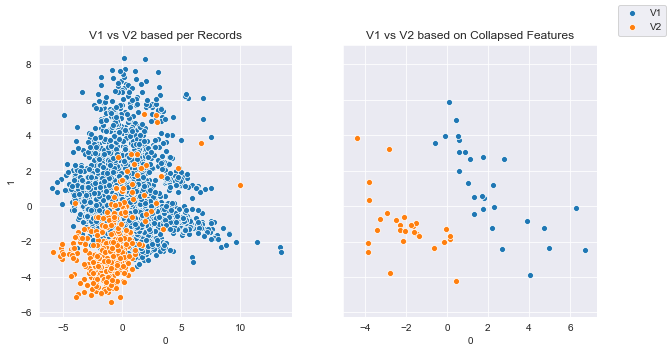

In [18]:
male_data = create_matching_dataset(walking_data_V1_male, 
                                    walking_data_V2_male)
ver_list = male_data[["healthCode", "version"]].drop_duplicates(keep = "first")
grouped_data =  pd.merge(male_data.groupby("healthCode").median().reset_index(), 
                ver_list, on = "healthCode", how = "inner")
grouped_data = grouped_data.drop(["PD", "age", "healthCode"], axis = 1)
ungrouped_data = male_data.drop(["recordId", "healthCode", "gender", "age"], axis = 1)
ungrouped_principal_df = generate_PCA(ungrouped_data)
grouped_principal_df = generate_PCA(grouped_data)
plot_comparisons(ungrouped_principal_df, grouped_principal_df)

### b. Balance Features

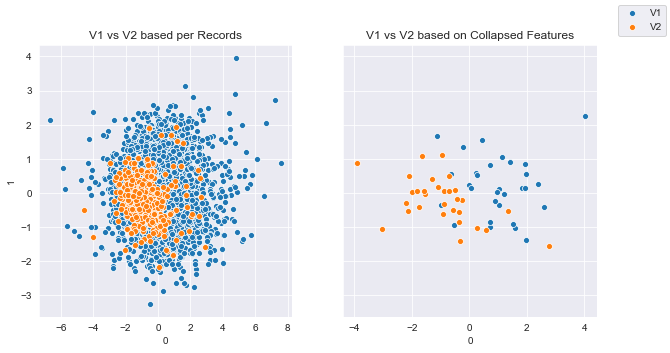

In [7]:
male_data = create_matching_dataset(balance_data_V1_male, 
                                    balance_data_V2_male)
ver_list = male_data[["healthCode", "version"]].drop_duplicates(keep = "first")
grouped_data =  pd.merge(male_data.groupby("healthCode").median().reset_index(), 
                ver_list, on = "healthCode", how = "inner")
grouped_data = grouped_data.drop(["PD", "age", "healthCode"], axis = 1)
ungrouped_data = male_data.drop(["recordId", "healthCode", "gender", "age"], axis = 1)
ungrouped_principal_df = generate_PCA(ungrouped_data)
grouped_principal_df = generate_PCA(grouped_data)
plot_comparisons(ungrouped_principal_df, grouped_principal_df)

## 2. Principal Component Plot on Female Groups

### a. Walking Features

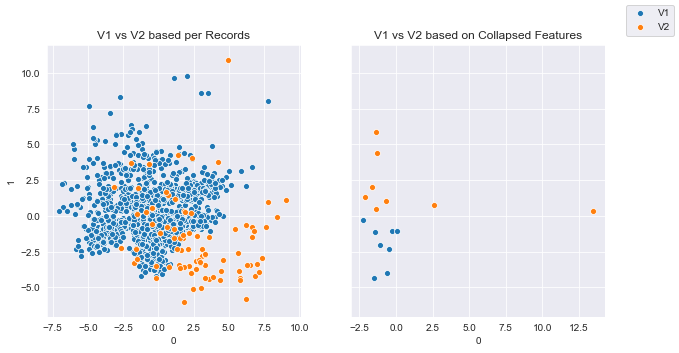

In [8]:
female_data = create_matching_dataset(walking_data_V1_female, 
                                      walking_data_V2_female)
ver_list = female_data[["healthCode", "version"]].drop_duplicates(keep = "first")
grouped_data =  pd.merge(female_data.groupby("healthCode").median().reset_index(), 
                ver_list, on = "healthCode", how = "inner")
grouped_data = grouped_data.drop(["PD", "age", "healthCode"], axis = 1)
ungrouped_data = female_data.drop(["recordId", "healthCode", "gender", "age"], axis = 1)
ungrouped_principal_df = generate_PCA(ungrouped_data)
grouped_principal_df = generate_PCA(grouped_data)
plot_comparisons(ungrouped_principal_df, grouped_principal_df)

### b. Balance Features

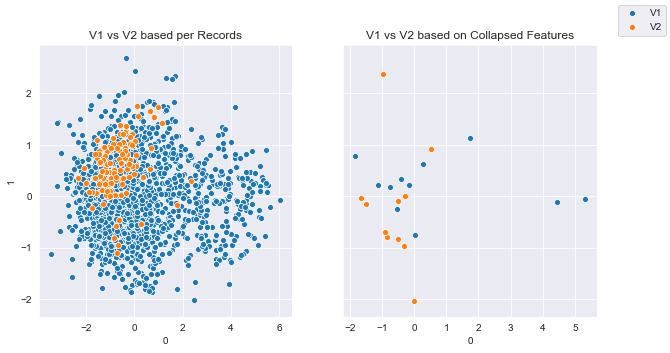

In [9]:
female_data = create_matching_dataset(balance_data_V1_female, 
                                      balance_data_V2_female)
ver_list = female_data[["healthCode", "version"]].drop_duplicates(keep = "first")
grouped_data =  pd.merge(female_data.groupby("healthCode").median().reset_index(), 
                ver_list, on = "healthCode", how = "inner")
grouped_data = grouped_data.drop(["PD", "age", "healthCode"], axis = 1)
ungrouped_data = female_data.drop(["recordId", "healthCode", "gender", "age"], axis = 1)
ungrouped_principal_df = generate_PCA(ungrouped_data)
grouped_principal_df = generate_PCA(grouped_data)
plot_comparisons(ungrouped_principal_df, grouped_principal_df)

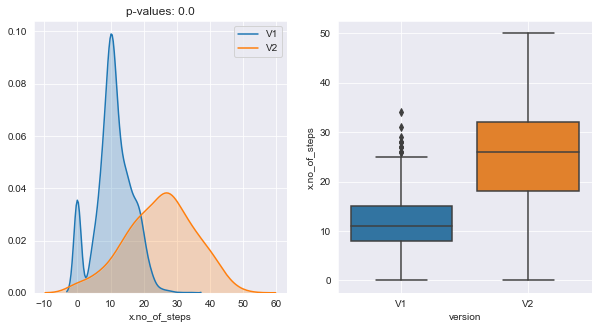

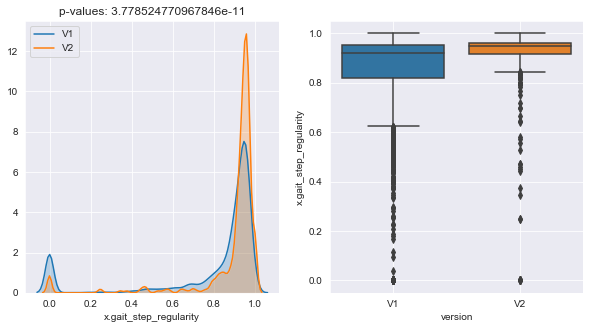

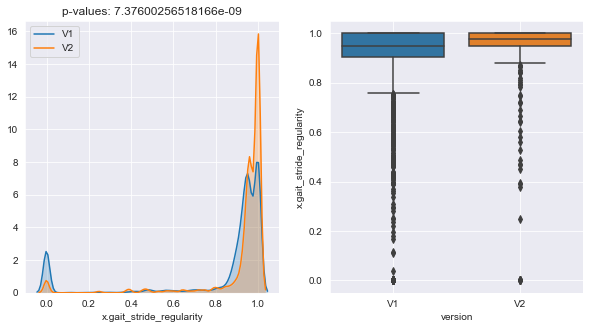

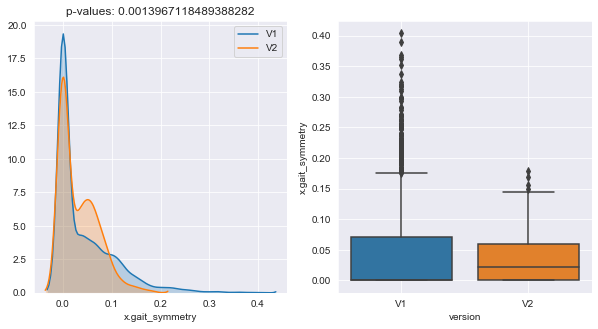

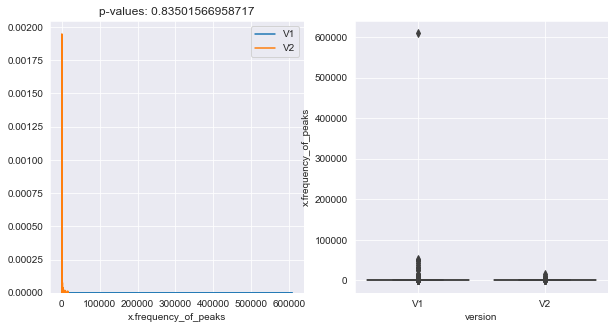

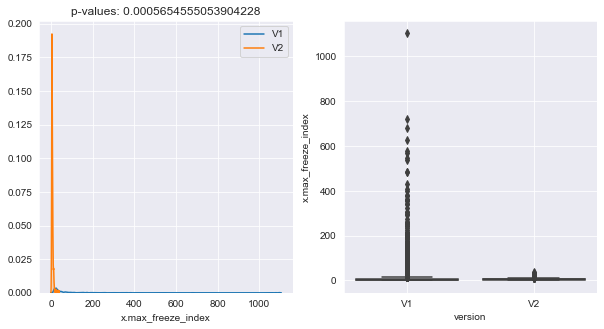

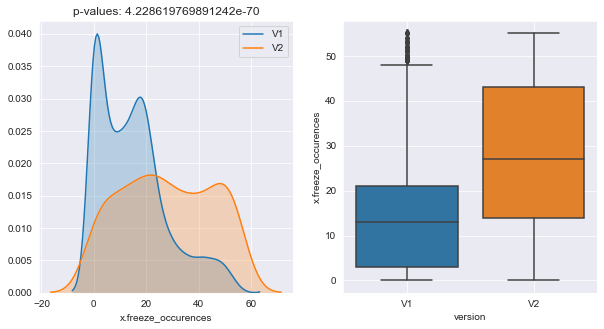

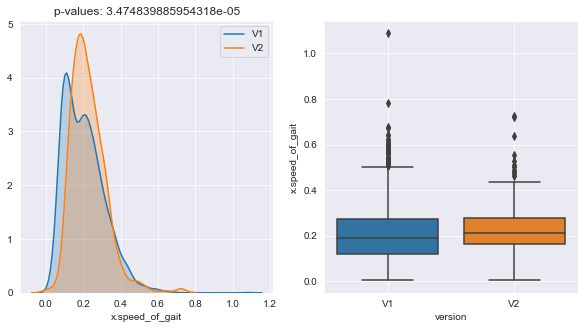

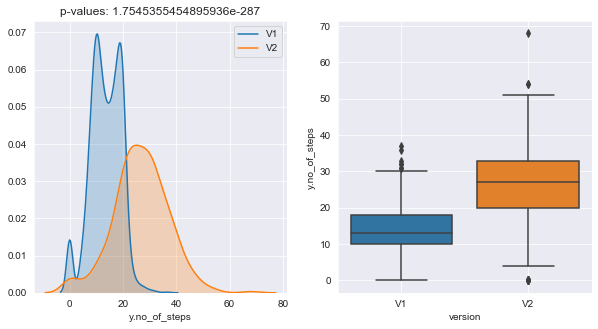

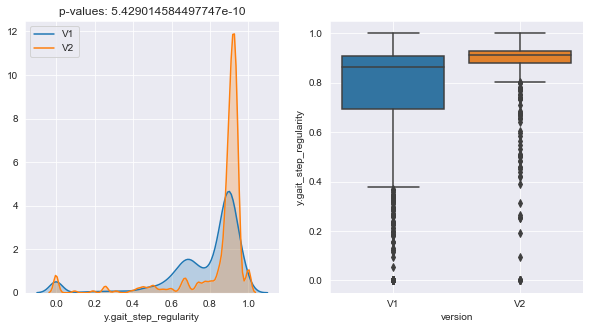

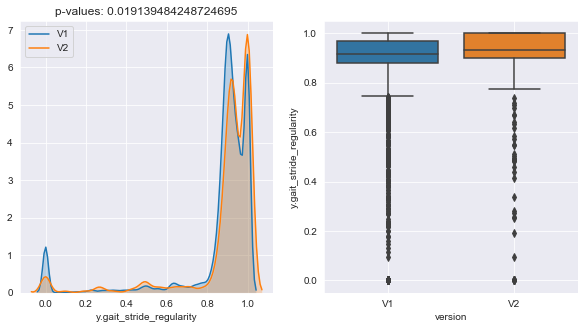

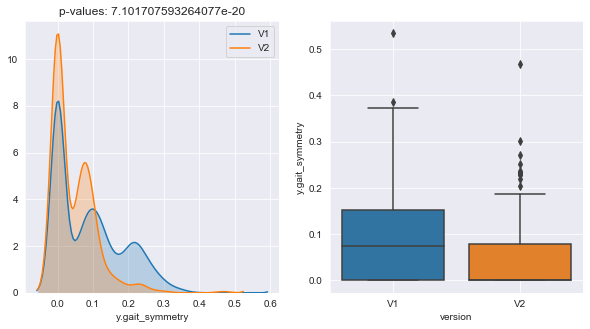

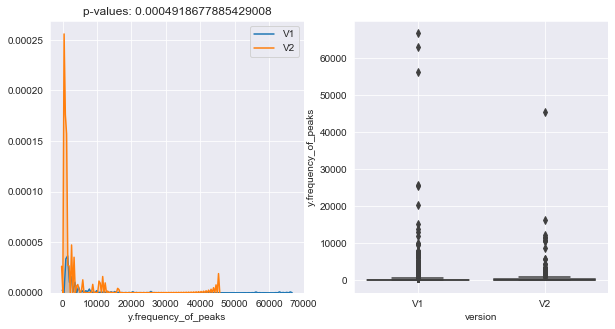

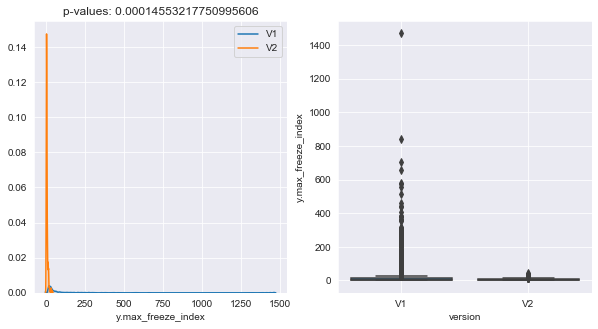

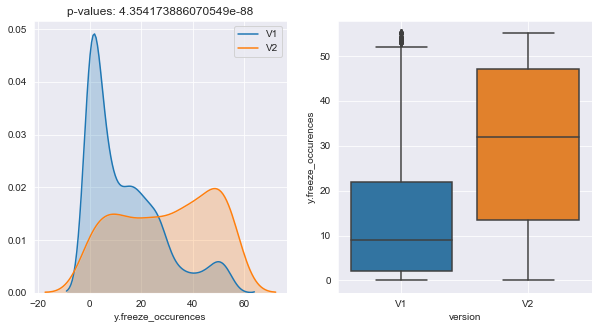

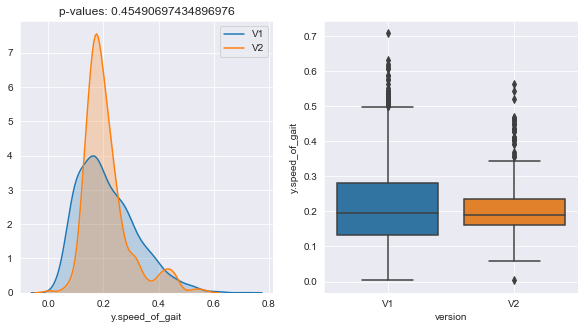

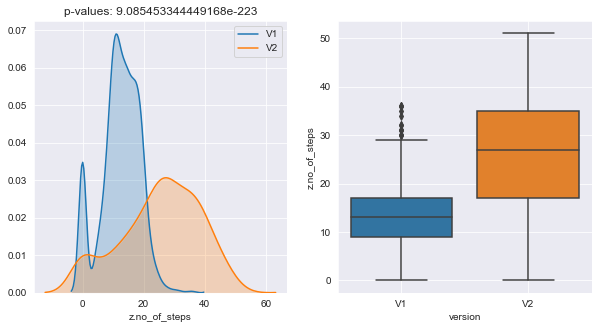

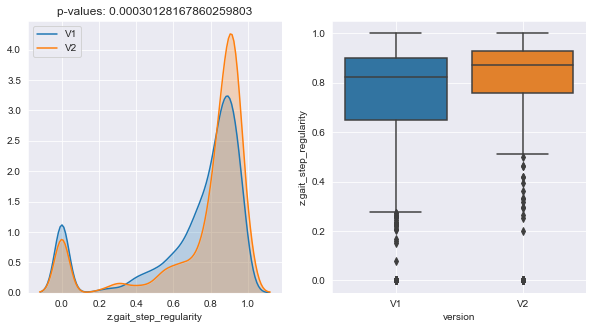

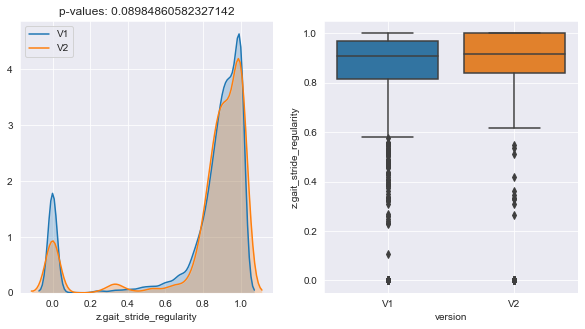

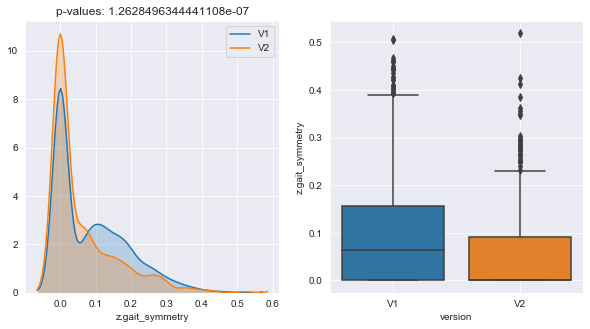

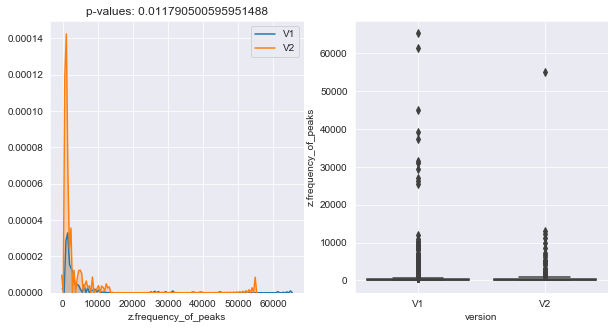

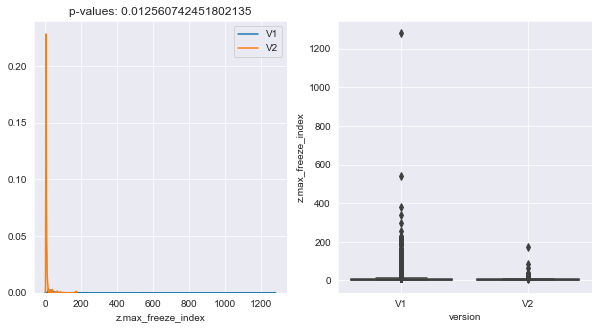

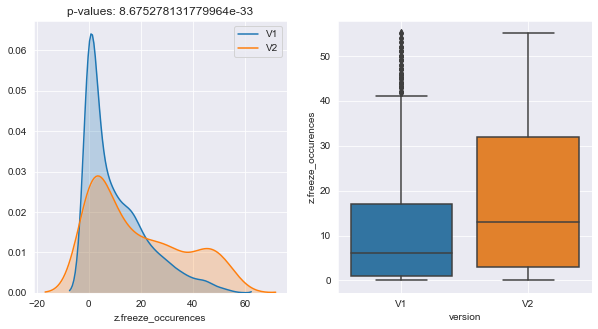

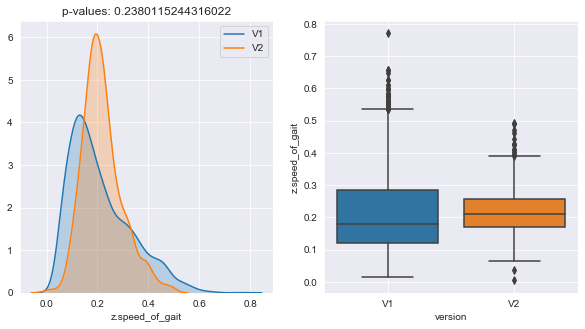

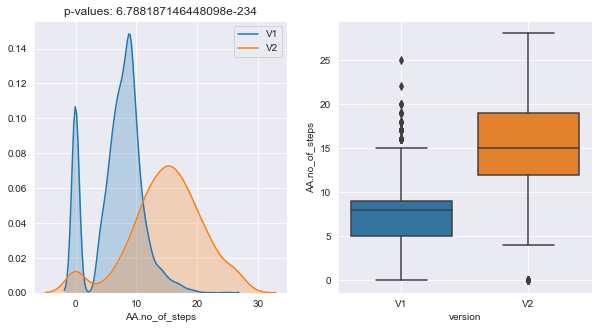

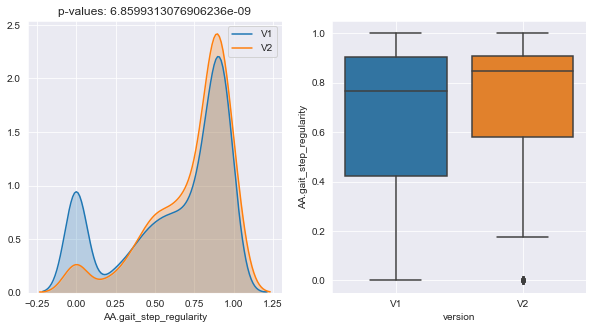

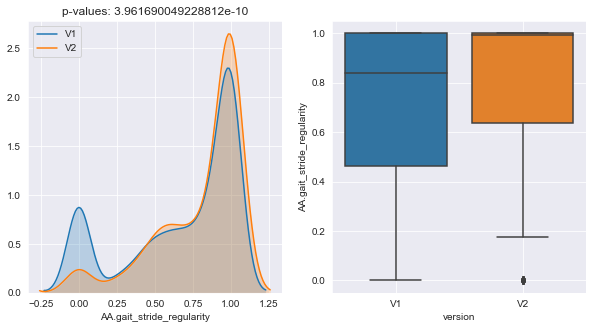

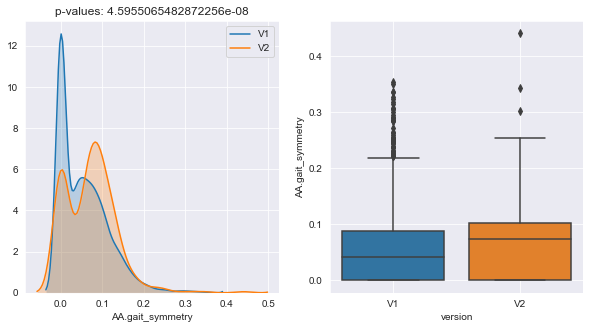

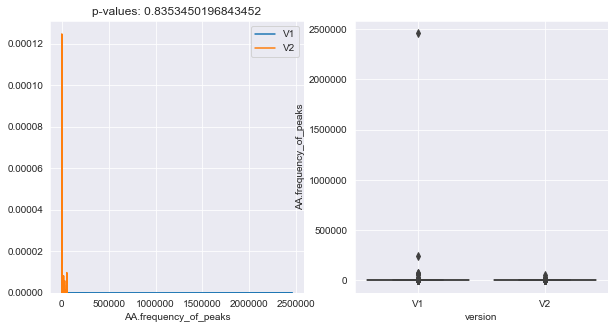

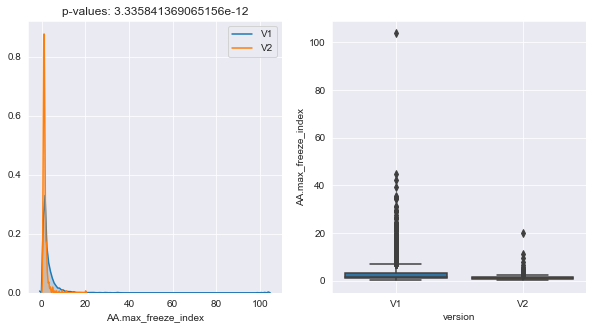

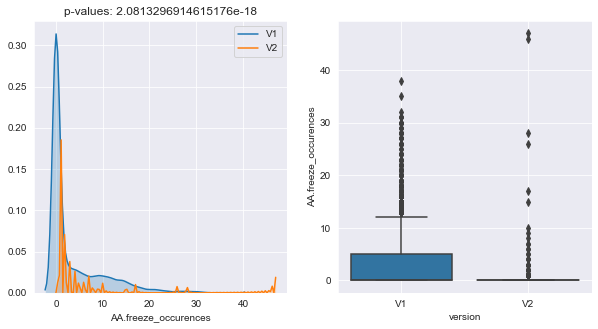

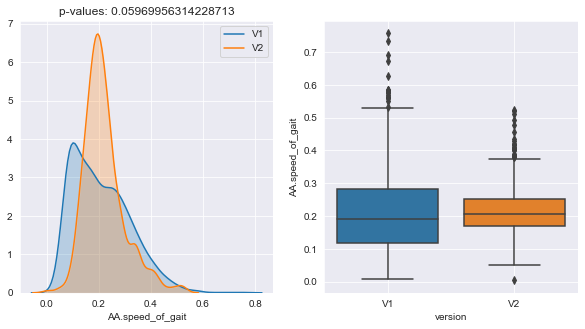

In [556]:
plot_distribution(male_data)

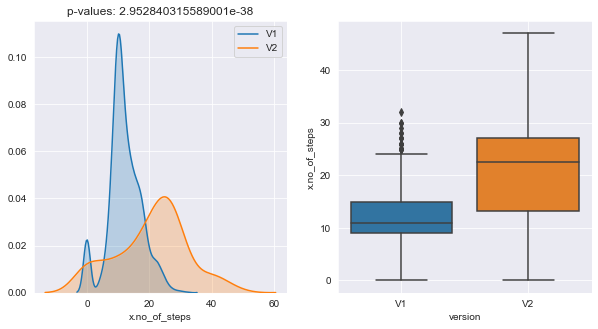

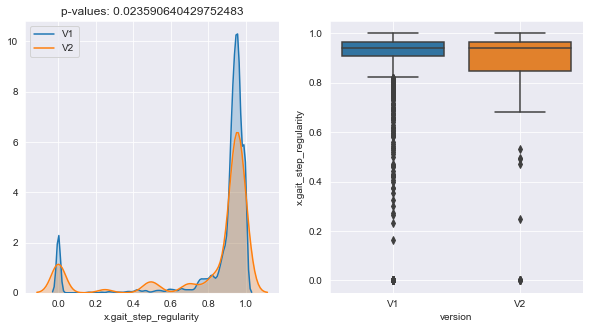

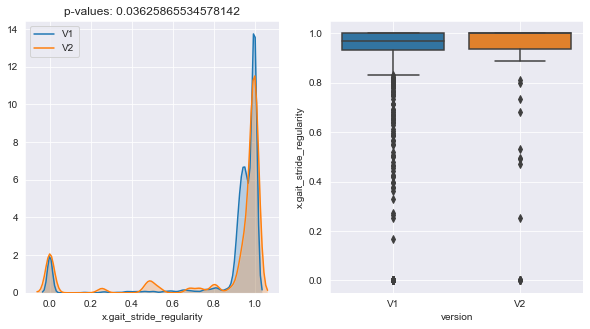

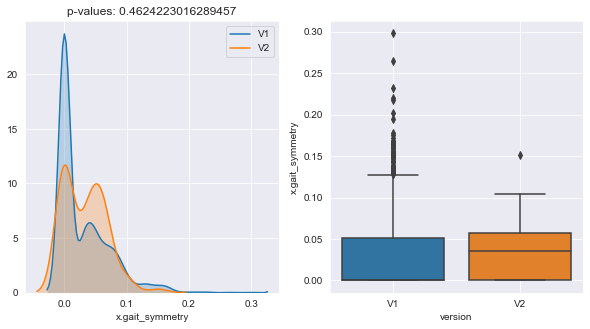

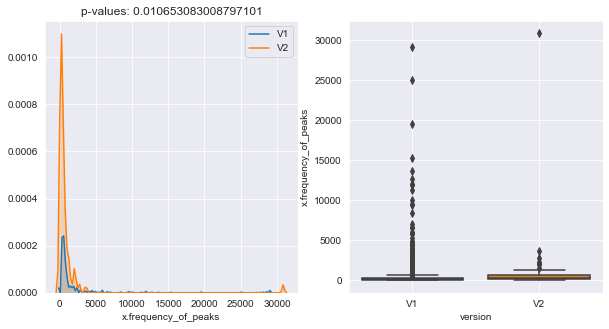

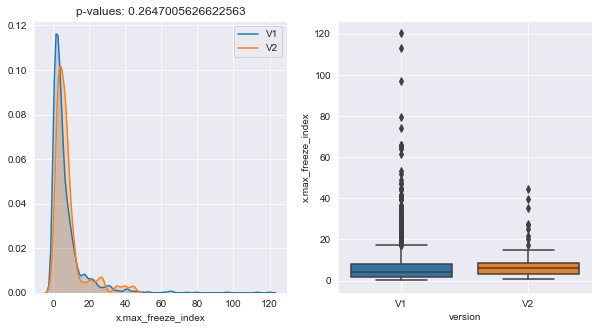

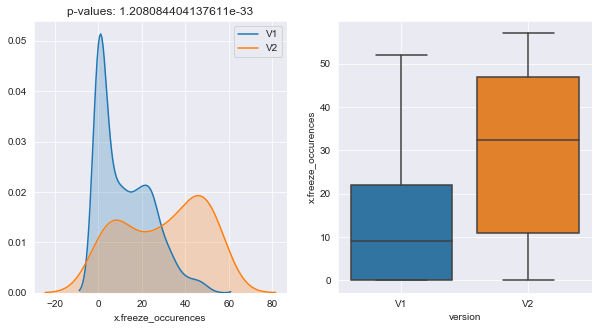

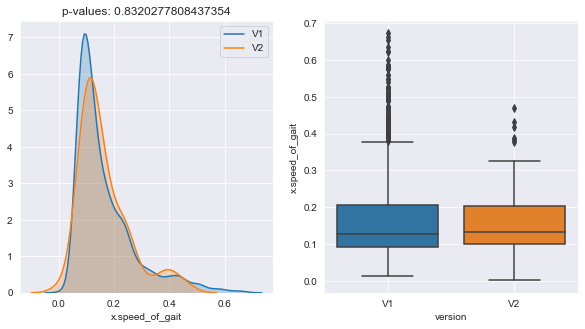

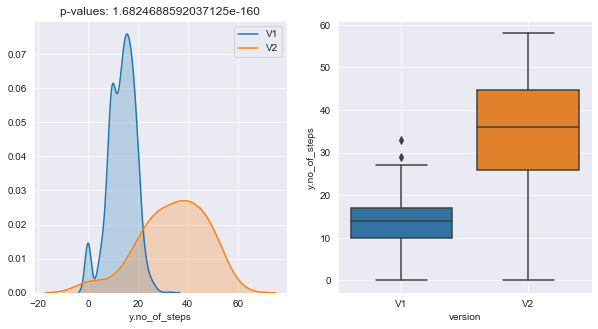

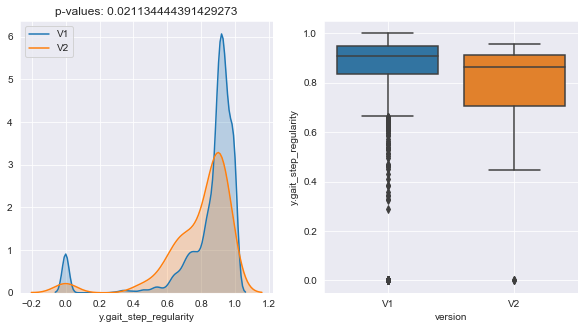

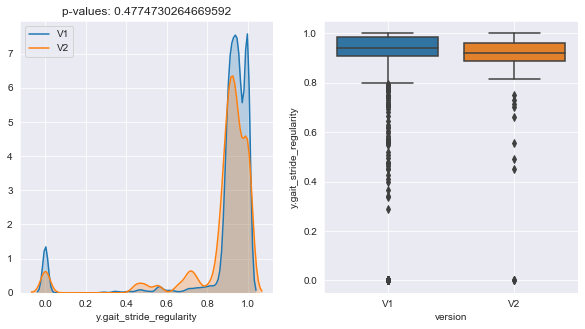

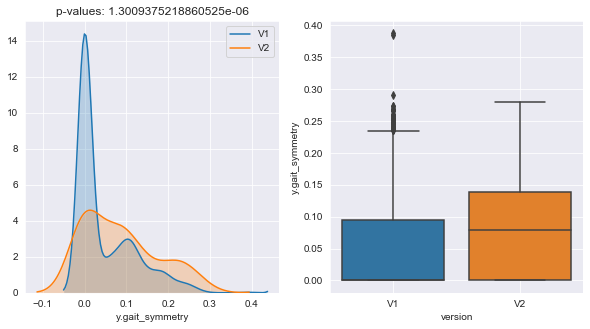

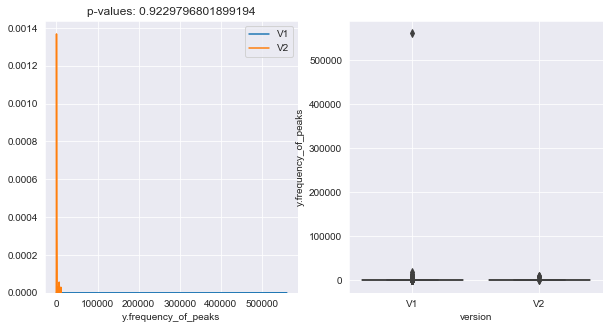

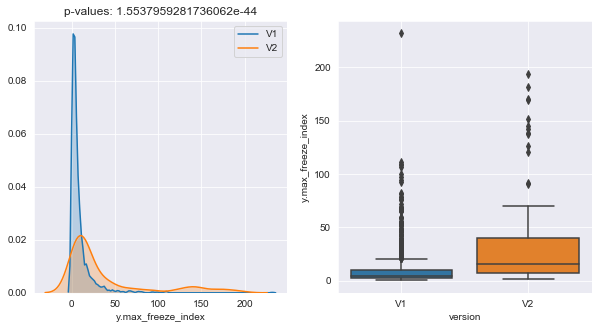

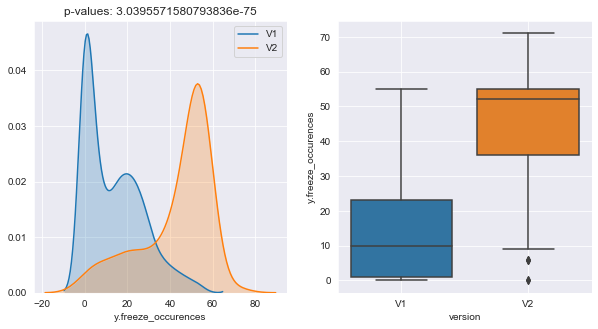

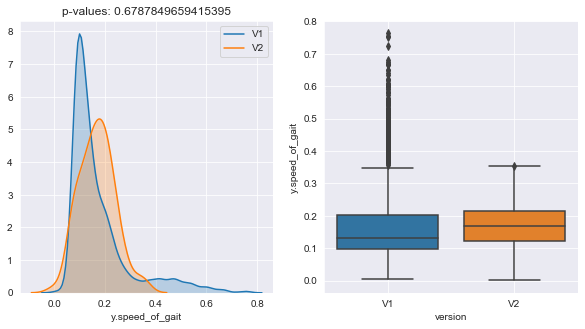

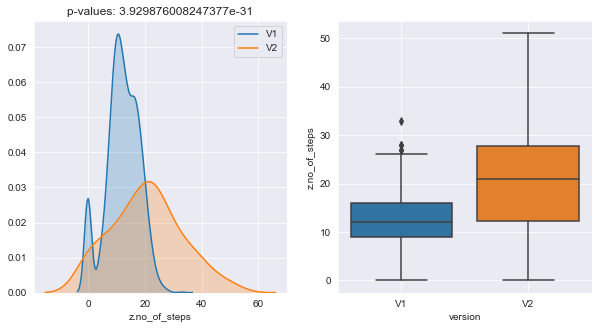

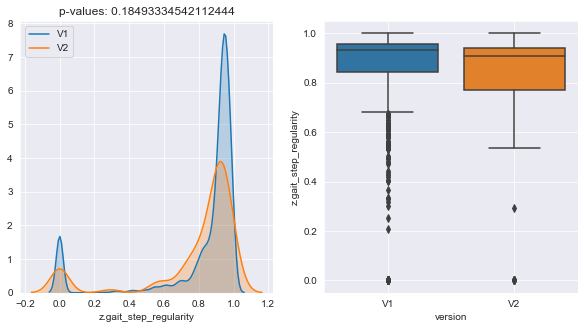

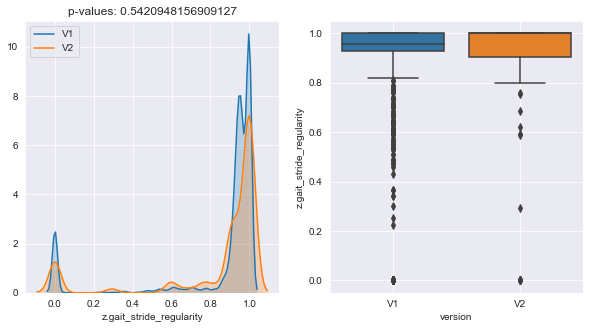

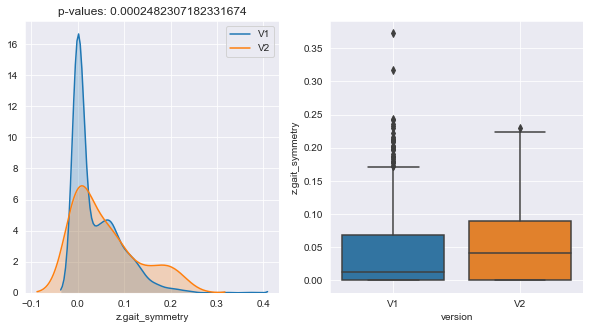

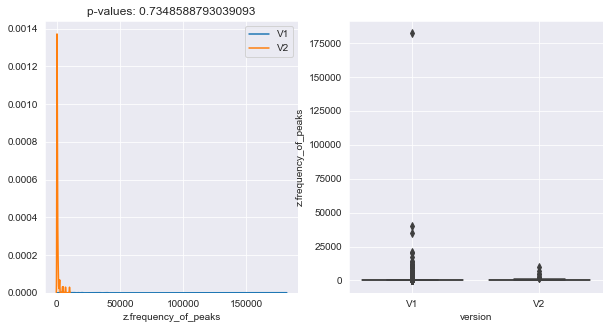

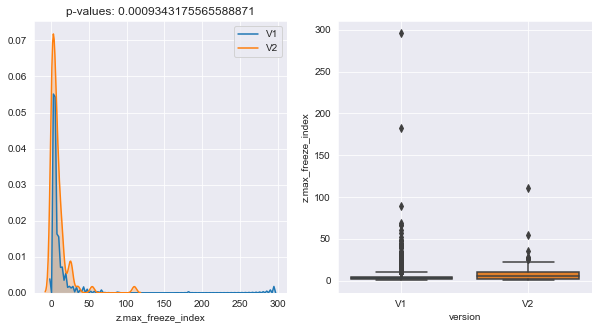

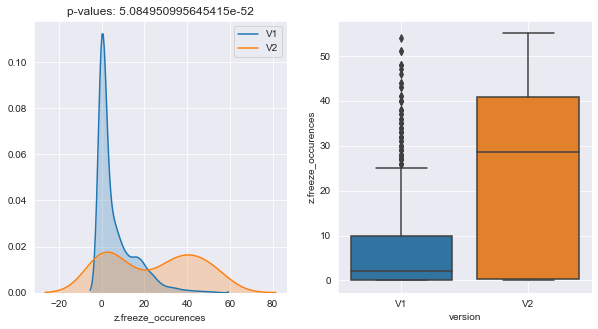

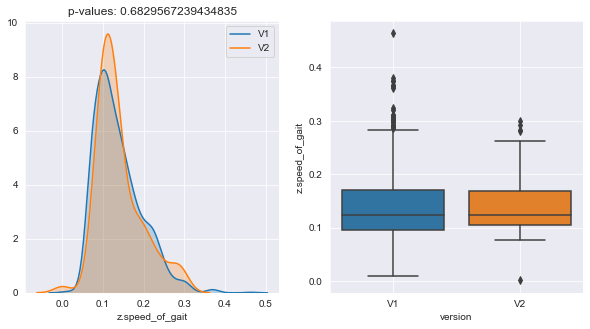

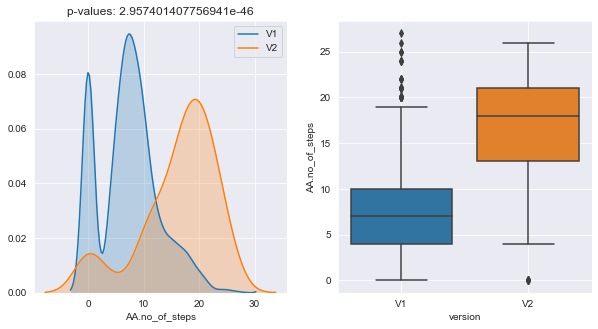

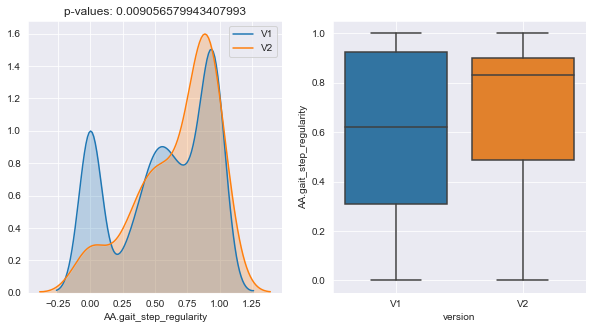

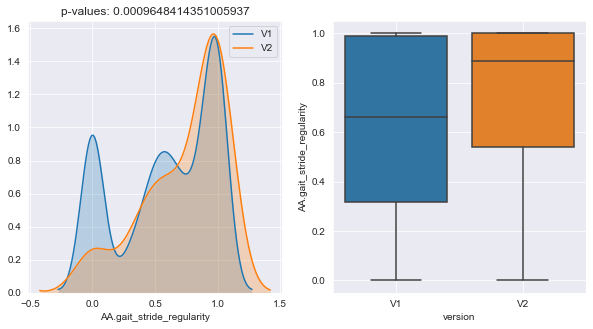

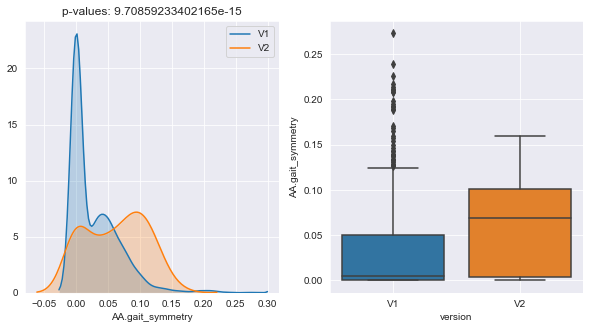

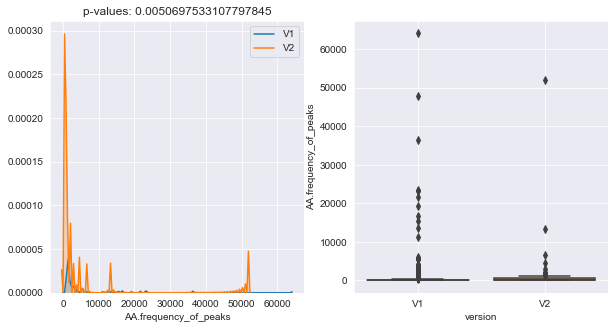

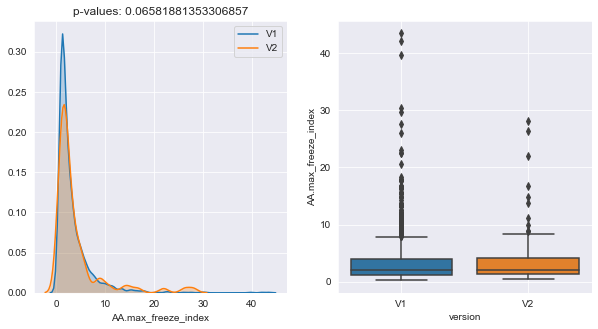

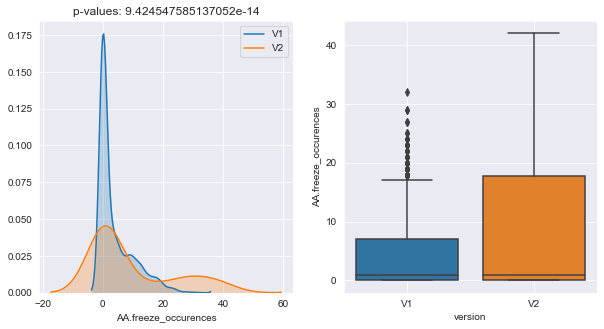

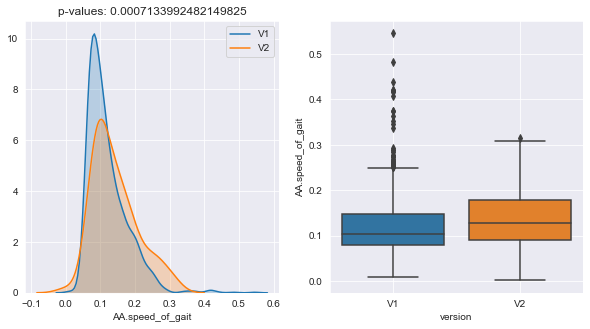

In [557]:
plot_distribution(female_data)